In [1]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
from mmdet.core import DatasetEnum
import mmcv


/opt/miniconda3/envs/co_dino/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
config_file = '/workspace/gaze_tokenize/Co-DETR-main/projects/configs/co_deformable_detr/co_deformable_detr_swin_large_1x_coco.py'
# download the checkpoint from model zoo and put it in `checkpoints/`
# url: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
checkpoint_file = '/workspace/gaze_tokenize/Co-DETR-main/save/deformable_withnms/epoch_20.pth'

In [ ]:
IMG_SIZE = 1024
TARGET_SIZE = 100
TOL = 3  # 浮点容差
for i in range(9,21):
    config_file = '/workspace/gaze_tokenize/Co-DETR-main/projects/configs/co_dino/co_dino_5scale_swin_large_16e_o365tococo copy.py'
    # download the checkpoint from model zoo and put it in `checkpoints/`
    # url: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
    checkpoint_file = f'/workspace/gaze_tokenize/Co-DETR-main/save/codinoswin_a_loss/epoch_{i}.pth'
    model = init_detector(config_file, checkpoint_file, DatasetEnum.COCO, device='cuda:6')
    from pathlib import Path
    import csv

    image_dir = Path("/workspace/gaze_tokenize/Co-DETR-main/data/coco/test2017")
    output_csv = f"codino_a_loss_e{i}.csv"
    with open(output_csv, mode='w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        # 写入表头
        writer.writerow(['id', 'image_filename', 'x', 'y', 'width', 'height', 'conf', 'class'])
        id = 0
        cls = 0
        thershold = 0 # set a thershold
        for img_path in image_dir.glob("*.png"):
            result = inference_detector(model, img_path)
            for res_i in range(len(result)):
                p = 0
                for x1, y1, x2, y2, conf in result[res_i]:
                    if conf > thershold:
                        cx = x1/2 + x2/2
                        cy = y1/2 + y2/2
                        w = x2-x1
                        h = y2-y1
                        x, y, w, h = cx,cy,w,h
        
                        left = x - w / 2
                        right = x + w / 2
                        top = y - h / 2
                        bottom = y + h / 2

                        # 默认不调整
                        new_left, new_right = left, right
                        new_top, new_bottom = top, bottom

                        # X 方向调整
                        if abs(left - 0) < TOL:
                            # 左边在边界，固定 right，向左扩展
                            new_left = new_right - TARGET_SIZE
                        elif abs(right - IMG_SIZE) < TOL:
                            # 右边在边界，固定 left，向右扩展
                            new_right = new_left + TARGET_SIZE

                        # Y 方向调整
                        if abs(top - 0) < TOL:
                            # 上边在边界，固定 bottom，向上扩展
                            new_top = new_bottom - TARGET_SIZE
                        elif abs(bottom - IMG_SIZE) < TOL:
                            # 下边在边界，固定 top，向下扩展
                            new_bottom = new_top + TARGET_SIZE

                        # 更新宽高和中心点
                        new_w = new_right - new_left
                        new_h = new_bottom - new_top
                        new_x = (new_left + new_right) / 2
                        new_y = (new_top + new_bottom) / 2

                        # 只有当至少一个方向被调整时，才强制设为 100（避免因浮点误差改变正常框）
                        # 但根据需求，只要碰到边界就变成 100x100
                        # 所以上面已经通过 TARGET_SIZE 确保了
                        if new_w < 100:
                            new = 101
                        if new_h < 100:
                            new_h = 101
                        writer.writerow([id, str(img_path).split('/')[-1], new_x, new_y, new_w, new_h, conf, res_i])
                        id+=1
                        if p == 100:
                            break
                        p += 1
                        
        

2026-02-20 13:00:17,693 - mmcv - INFO - initialize RPNHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01}
2026-02-20 13:00:17,699 - mmcv - INFO - 
rpn_conv.weight - torch.Size([256, 256, 3, 3]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2026-02-20 13:00:17,700 - mmcv - INFO - 
rpn_conv.bias - torch.Size([256]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2026-02-20 13:00:17,701 - mmcv - INFO - 
rpn_cls.weight - torch.Size([9, 256, 1, 1]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2026-02-20 13:00:17,702 - mmcv - INFO - 
rpn_cls.bias - torch.Size([9]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2026-02-20 13:00:17,703 - mmcv - INFO - 
rpn_reg.weight - torch.Size([36, 256, 1, 1]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2026-02-20 13:00:17,704 - mmcv - INFO - 
rpn_reg.bias - torch.Size([36]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2026-02-20 13:00:17,820 - mmcv - INFO - initialize Shared2FCBBoxHead with init_cfg [{'type': 'Normal', 'std': 0.01, 'override': {'name': 'fc_cls'

KeyboardInterrupt: 

In [ ]:
# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, DatasetEnum.COCO, device='cuda:4')

2026-02-15 01:44:10,284 - mmcv - INFO - initialize RPNHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01}
2026-02-15 01:44:10,292 - mmcv - INFO - 
rpn_conv.weight - torch.Size([256, 256, 3, 3]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2026-02-15 01:44:10,293 - mmcv - INFO - 
rpn_conv.bias - torch.Size([256]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2026-02-15 01:44:10,294 - mmcv - INFO - 
rpn_cls.weight - torch.Size([9, 256, 1, 1]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2026-02-15 01:44:10,294 - mmcv - INFO - 
rpn_cls.bias - torch.Size([9]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2026-02-15 01:44:10,295 - mmcv - INFO - 
rpn_reg.weight - torch.Size([36, 256, 1, 1]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2026-02-15 01:44:10,296 - mmcv - INFO - 
rpn_reg.bias - torch.Size([36]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2026-02-15 01:44:10,410 - mmcv - INFO - initialize Shared2FCBBoxHead with init_cfg [{'type': 'Normal', 'std': 0.01, 'override': {'name': 'fc_cls'

In [3]:
IMG_SIZE = 1024
TARGET_SIZE = 100
TOL = 3  # 浮点容差
for i in range(4,19):
    config_file = '/workspace/gaze_tokenize/Co-DETR-main/projects/configs/co_dino/co_dino_5scale_swin_large_16e_o365tococo copy.py'
    # download the checkpoint from model zoo and put it in `checkpoints/`
    # url: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
    checkpoint_file = f'/workspace/gaze_tokenize/Co-DETR-main/save/codinoswin_a_merge/epoch_{i}.pth'
    model = init_detector(config_file, checkpoint_file, DatasetEnum.COCO, device='cuda:2')
    from pathlib import Path
    import csv

    image_dir = Path("/workspace/gaze_tokenize/Co-DETR-main/data/coco/test2017")
    output_csv = f"codinoswin_a_merge_e{i}.csv"
    with open(output_csv, mode='w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        # 写入表头
        writer.writerow(['id', 'image_filename', 'x', 'y', 'width', 'height', 'conf', 'class'])
        id = 0
        cls = 0
        thershold = 0 # set a thershold
        for img_path in image_dir.glob("*.png"):
            result = inference_detector(model, img_path)
            for res_i in range(len(result)):
                for x1, y1, x2, y2, conf in result[res_i]:
                    if conf > thershold:
                        cx = int(x1/2 + x2/2)
                        cy = int(y1/2 + y2/2)
                        w = int(x2-x1)
                        h = int(y2-y1)
                        x, y, w, h = cx,cy,w,h
        
                        left = x - w / 2
                        right = x + w / 2
                        top = y - h / 2
                        bottom = y + h / 2

                        # 默认不调整
                        new_left, new_right = left, right
                        new_top, new_bottom = top, bottom

                        # X 方向调整
                        if abs(left - 0) < TOL:
                            # 左边在边界，固定 right，向左扩展
                            new_left = new_right - TARGET_SIZE
                        elif abs(right - IMG_SIZE) < TOL:
                            # 右边在边界，固定 left，向右扩展
                            new_right = new_left + TARGET_SIZE

                        # Y 方向调整
                        if abs(top - 0) < TOL:
                            # 上边在边界，固定 bottom，向上扩展
                            new_top = new_bottom - TARGET_SIZE
                        elif abs(bottom - IMG_SIZE) < TOL:
                            # 下边在边界，固定 top，向下扩展
                            new_bottom = new_top + TARGET_SIZE

                        # 更新宽高和中心点
                        new_w = new_right - new_left
                        new_h = new_bottom - new_top
                        new_x = (new_left + new_right) / 2
                        new_y = (new_top + new_bottom) / 2

                        # 只有当至少一个方向被调整时，才强制设为 100（避免因浮点误差改变正常框）
                        # 但根据需求，只要碰到边界就变成 100x100
                        # 所以上面已经通过 TARGET_SIZE 确保了

                        writer.writerow([id, str(img_path).split('/')[-1], new_x, new_y, 101, 101, conf, res_i])
                        id+=1
        

2026-02-17 14:34:40,097 - mmcv - INFO - initialize RPNHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01}
2026-02-17 14:34:40,104 - mmcv - INFO - 
rpn_conv.weight - torch.Size([256, 256, 3, 3]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2026-02-17 14:34:40,105 - mmcv - INFO - 
rpn_conv.bias - torch.Size([256]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2026-02-17 14:34:40,106 - mmcv - INFO - 
rpn_cls.weight - torch.Size([9, 256, 1, 1]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2026-02-17 14:34:40,108 - mmcv - INFO - 
rpn_cls.bias - torch.Size([9]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2026-02-17 14:34:40,109 - mmcv - INFO - 
rpn_reg.weight - torch.Size([36, 256, 1, 1]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2026-02-17 14:34:40,110 - mmcv - INFO - 
rpn_reg.bias - torch.Size([36]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2026-02-17 14:34:40,232 - mmcv - INFO - initialize Shared2FCBBoxHead with init_cfg [{'type': 'Normal', 'std': 0.01, 'override': {'name': 'fc_cls'

In [21]:
# test a single image
img = '/workspace/gaze_tokenize/Co-DETR-main/data/coco/test2017/ASCUS_1_patch01.png'
result = inference_detector(model, img)

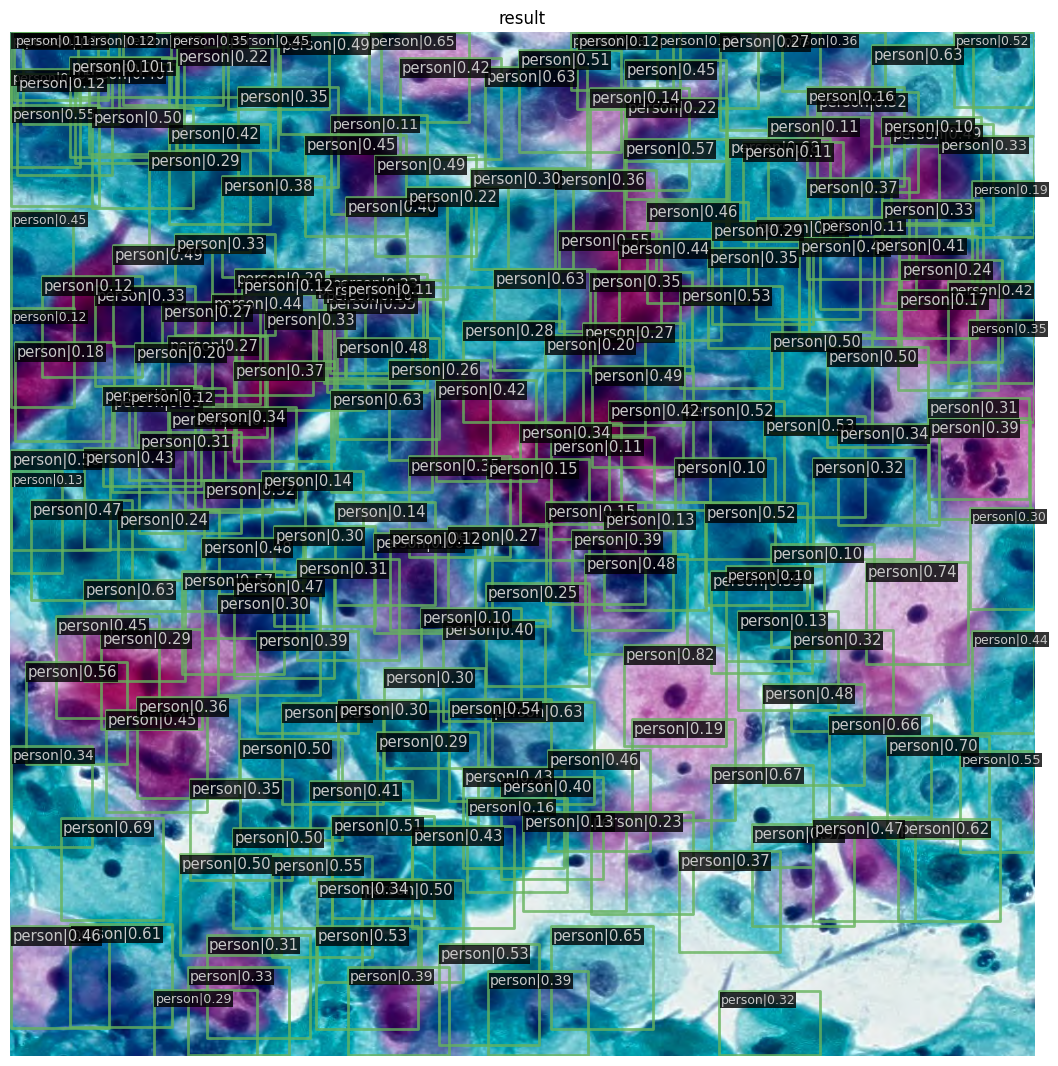

80
(300, 5)
[]
[8.554077e+02 5.308954e+02 9.571644e+02 6.326504e+02 7.390909e-01]
1024.0


In [5]:
# show the results
show_result_pyplot(model, img, result,score_thr=0.1)
print(len(result))
print(result[0].shape)
print(result[1])
max_third = max(sublist[3] for sublist in result[0])
print(result[0][1])
print(max_third)  # 输出: 15)

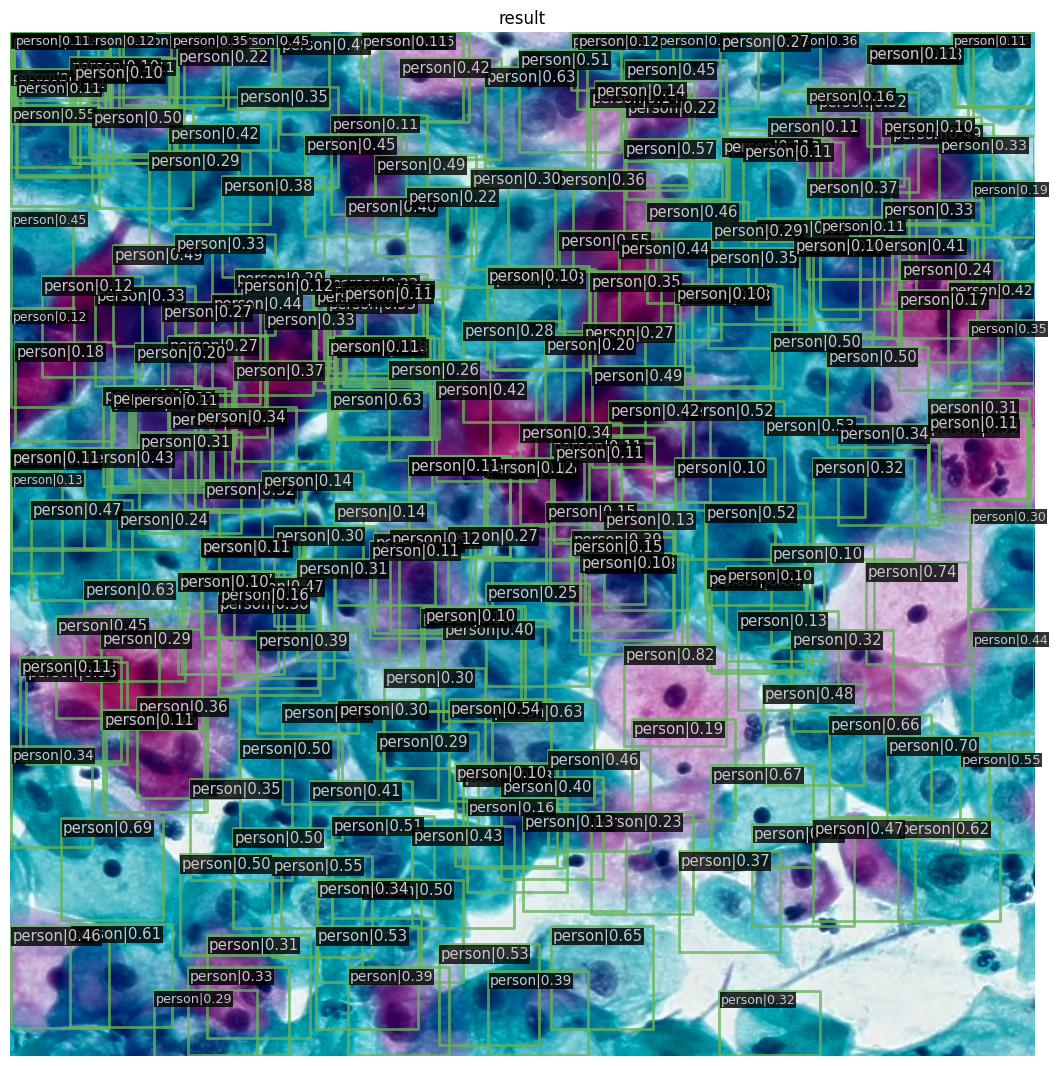

80
(300, 5)
[]
[8.554077e+02 5.308954e+02 9.571644e+02 6.326504e+02 7.390909e-01]
1024.0


In [22]:
show_result_pyplot(model, img, result,score_thr=0.1)
print(len(result))
print(result[0].shape)
print(result[1])
max_third = max(sublist[3] for sublist in result[0])
print(result[0][1])
print(max_third)  # 输出: 15)

In [31]:
from pathlib import Path
import csv

image_dir = Path("/workspace/gaze_tokenize/Co-DETR-main/data/coco/test2017")
output_csv = "co_deformable_detr_swin_final_merge_inferwithoutnms_e20.csv"
with open(output_csv, mode='w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    # 写入表头
    writer.writerow(['id', 'image_filename', 'x', 'y', 'width', 'height', 'conf', 'class'])
    id = 0
    cls = 0
    thershold = 0 # set a thershold
    for img_path in image_dir.glob("*.png"):
        result = inference_detector(model, img_path)
        for x1, y1, x2, y2, conf in result[0]:
            if conf > thershold:
                cx = int(x1/2 + x2/2)
                cy = int(y1/2 + y2/2)
                w = int(x2-x1)
                h = int(y2-y1)
                writer.writerow([id, str(img_path).split('/')[-1], cx, cy, w, h, conf, cls])
                id+=1
    